## Digital Africa Plantation Counting Challenge

### Installing and Importing the Necessary Libraries

In [ ]:
!pip install -U albumentations
!pip install opencv-python==4.5.4.60
!pip install timm

In [2]:

import torch
torch.cuda.empty_cache()

In [3]:
import os
import albumentations
from albumentations.pytorch import ToTensorV2
import pandas as pd
import numpy as np
import gc
import timm
from fastai.vision.all import *
from PIL import Image
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

### Seeding for Reproducibility

In [4]:
def random_seed(seed_value, use_cuda): 
    np.random.seed(seed_value)
 #cpu vars
    torch.manual_seed(seed_value) 
# cpu  vars
    random.seed(seed_value)
 # Python 
    if use_cuda: 
        torch.cuda.manual_seed(seed_value) 
        torch.cuda.manual_seed_all(seed_value) 
# gpu vars
        torch.backends.cudnn.deterministic = True 
 #needed
        torch.backends.cudnn.benchmark = False 
#Remember to use num_workers=0 when creating the DataBunch.

random_seed(2022,True)

### Loading The Datasets

In [5]:
path = "/kaggle/input/trees-project/tree_project/tree_project/"
train = pd.read_csv(path+'Train.csv')
test = pd.read_csv(path+'Test.csv')
class_test = pd.read_csv('/kaggle/input/trees-project/classified_test.csv')
Sub = pd.read_csv(path+'SampleSubmission.csv')

print(train.shape, test.shape, Sub.shape)
display(train.head(), test.head(), Sub)

(2002, 2) (858, 1) (858, 2)


,ImageId,Target
0,Id_jdqw9hlv6j.png,14.0
1,Id_6xtrolmuvc.png,18.0
2,Id_2m49sj3xd9.png,0.0
3,Id_9jwg5pcnn4.png,28.0
4,Id_vnm6e8n0p3.png,21.0


,ImageId
0,Id_ohk78h9ld8.png
1,Id_eeyj2u4j7y.png
2,Id_wsd7vx2ifa.png
3,Id_6vfneamaoh.png
4,Id_9wil3575fv.png


,ImageId,Target
0,Id_ohk78h9ld8.png,0
1,Id_eeyj2u4j7y.png,0
2,Id_wsd7vx2ifa.png,0
3,Id_6vfneamaoh.png,0
4,Id_9wil3575fv.png,0
...,...,...
853,Id_lmvuv1pm3a.png,0
854,Id_ez9lb2o6b1.png,0
855,Id_jeou44iven.png,0
856,Id_341bsipcnk.png,0


### Target Distribution

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Target', ylabel='Density'>

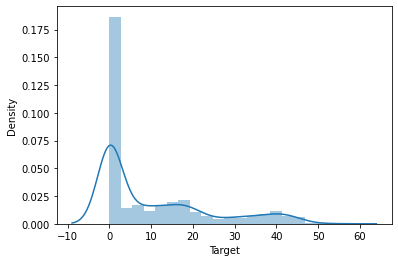

In [11]:
import seaborn as sns
sns.distplot(train['Target'])

### Cross Validation - Stratified KFold


In [13]:

from sklearn.model_selection import StratifiedKFold
n_splits = 5
seed = 21
Train = train.copy()
Test = test.copy()
kf = StratifiedKFold(n_splits, shuffle=True, random_state=seed)
Train['fold'] = 0  

for fold, (_, val_inx) in enumerate(kf.split(Train, Train['Target'])):
  Train.loc[val_inx, "fold"] = fold 


img_path = path + "TreeImages/"
Train["ImageId"] = img_path + Train.ImageId
Test["ImageId"] = img_path + Test.ImageId
# Sub["ImageId"] = img_path + Sub.ImageId

display(Train.head(), Test.head())

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


,ImageId,Target,fold
0,/kaggle/input/trees-project/tree_project/tree_project/TreeImages/Id_jdqw9hlv6j.png,14.0,0
1,/kaggle/input/trees-project/tree_project/tree_project/TreeImages/Id_6xtrolmuvc.png,18.0,0
2,/kaggle/input/trees-project/tree_project/tree_project/TreeImages/Id_2m49sj3xd9.png,0.0,1
3,/kaggle/input/trees-project/tree_project/tree_project/TreeImages/Id_9jwg5pcnn4.png,28.0,1
4,/kaggle/input/trees-project/tree_project/tree_project/TreeImages/Id_vnm6e8n0p3.png,21.0,3


,ImageId
0,/kaggle/input/trees-project/tree_project/tree_project/TreeImages/Id_ohk78h9ld8.png
1,/kaggle/input/trees-project/tree_project/tree_project/TreeImages/Id_eeyj2u4j7y.png
2,/kaggle/input/trees-project/tree_project/tree_project/TreeImages/Id_wsd7vx2ifa.png
3,/kaggle/input/trees-project/tree_project/tree_project/TreeImages/Id_6vfneamaoh.png
4,/kaggle/input/trees-project/tree_project/tree_project/TreeImages/Id_9wil3575fv.png


#### Mean Confirmation accross folds

In [14]:
Train.groupby('fold').mean()

,Target
fold,
0,10.266833
1,10.286783
2,10.202500
3,10.147500
4,10.432500


### Augmentations Using Albumentations

In [15]:
class AlbumentationsTransform (RandTransform):
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [16]:
def get_train_aug(): return albumentations.Compose([
            albumentations.Resize(256, 256), #Extra tip, use size that's suitable for the efficentNetwork you are using.

            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            
            albumentations.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
            

            
            ], p=1.)



def get_valid_aug(): return albumentations.Compose([
            albumentations.Resize(256, 256),
            ], p=1.0)

item_tfms = AlbumentationsTransform(get_train_aug(), get_valid_aug())
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

### FASTAI DataLoaders

In [17]:
# to learn more about datablocks in fast you have to visit fastai.docs
def get_data(fold=0, bs=32):
    return DataBlock(blocks=(ImageBlock,RegressionBlock),
                get_x=ColReader("ImageId"),
                get_y=ColReader(['Target']),
                splitter=IndexSplitter(Train[Train.fold == fold].index),
                item_tfms = item_tfms,
                batch_tfms = batch_tfms).dataloaders(Train, bs=bs)

In [18]:
dls = DataBlock(blocks=(ImageBlock,RegressionBlock),
                get_x=ColReader("ImageId"),
                get_y=ColReader(['Target']),
                splitter=IndexSplitter(Train[Train.fold == fold].index),
                item_tfms = item_tfms,
                batch_tfms = batch_tfms).dataloaders(Train, bs=32)

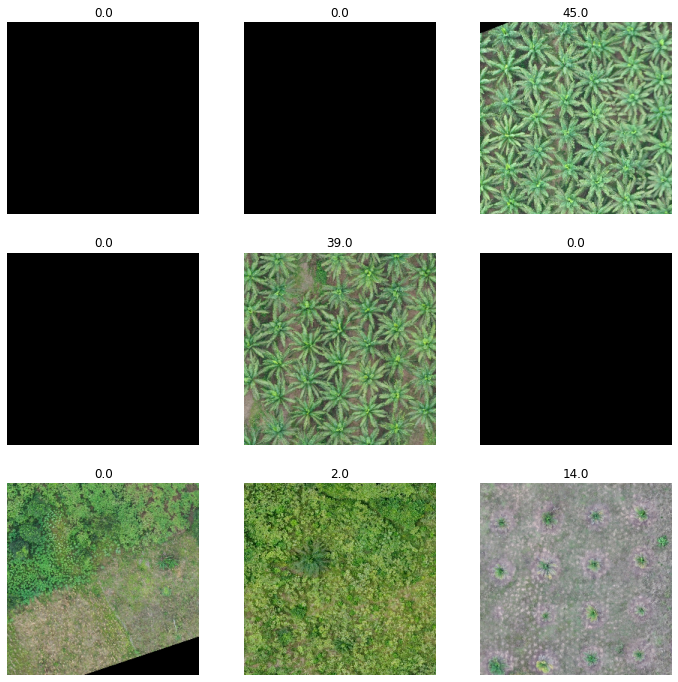

In [19]:
dls.show_batch(figsize=(12,12))

### Models + Metrics

In [20]:
from fastai.metrics import mse, rmse, mae
timm.list_models('conv*')

['convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

### Convnext Architecture: 

In [23]:
"""
My palm tree counter model : Credits to : Daniel Bruinjties: https://www.linkedin.com/in/daniel-bruintjies-linked/
"""

class SelfAttention(nn.Module):
    def __init__(self, in_channels, key_channels=None, value_channels=None, out_channels=None):
        super(SelfAttention, self).__init__()

        self.key_channels = key_channels if key_channels is not None else in_channels // 8
        self.value_channels = value_channels if value_channels is not None else in_channels // 2
        self.out_channels = out_channels if out_channels is not None else in_channels

        self.query_conv = nn.Conv2d(in_channels, self.key_channels, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, self.key_channels, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, self.value_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.out_conv = nn.Conv2d(self.value_channels, self.out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(self.out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        batch_size, channels, height, width = x.size()

        query = self.query_conv(x).view(batch_size, self.key_channels, -1)
        key = self.key_conv(x).view(batch_size, self.key_channels, -1)
        value = self.value_conv(x).view(batch_size, self.value_channels, -1)

        energy = torch.bmm(query.transpose(1, 2), key)
        attention = F.softmax(energy, dim=-1)

        out = torch.bmm(value, attention.transpose(1, 2))
        out = out.view(batch_size, self.value_channels, height, width)

        out = self.out_conv(out)
        out = self.bn(out)
        out = self.relu(out)

        out = self.gamma * out + x
        return out

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = timm.create_model('convnext_base', pretrained=True)
        self.attention1 = SelfAttention(in_channels=1024)
        self.attention2 = SelfAttention(in_channels=1024)
        self.fc = nn.Linear(1024, 1)

    def forward(self, image):
        x = self.model.forward_features(image)
        x = self.attention1(x)
        x = self.attention2(x)
        x = x.mean(dim=[2, 3])
        x = self.fc(x)

        return x

### Modelling: Fold training + Prediction

epoch,train_loss,valid_loss,_rmse,mae,time
0,40.588184,6.735085,2.595204,1.682973,01:26


Better model found at epoch 0 with valid_loss value: 6.7350850105285645.


epoch,train_loss,valid_loss,_rmse,mae,time
0,9.172170,4.563141,2.136151,1.312704,01:26
1,8.207876,5.248580,2.290978,1.397334,01:26
2,10.905025,6.838836,2.615117,1.567868,01:26
3,9.447321,7.147958,2.673566,1.691038,01:26
4,7.052285,5.266827,2.294957,1.491194,01:26
5,6.564112,4.949376,2.224719,1.461186,01:27
6,4.441153,4.066811,2.016633,1.242952,01:26
7,3.240129,3.470529,1.862936,1.111755,01:26
8,3.084480,4.789871,2.188577,1.356966,01:27
9,2.507410,2.958512,1.720033,1.033198,01:26


Better model found at epoch 0 with valid_loss value: 4.563140869140625.
Better model found at epoch 6 with valid_loss value: 4.0668110847473145.
Better model found at epoch 7 with valid_loss value: 3.470529079437256.
Better model found at epoch 9 with valid_loss value: 2.958512306213379.
Better model found at epoch 11 with valid_loss value: 2.9160585403442383.
Better model found at epoch 12 with valid_loss value: 2.7811005115509033.
Better model found at epoch 14 with valid_loss value: 2.773096799850464.


epoch,train_loss,valid_loss,_rmse,mae,time
0,42.159283,8.599958,2.932569,1.591084,01:27


Better model found at epoch 0 with valid_loss value: 8.599958419799805.


epoch,train_loss,valid_loss,_rmse,mae,time
0,8.315801,9.171845,3.028505,1.622730,01:26
1,7.855768,9.399683,3.065890,1.574859,01:27
2,6.956574,9.231267,3.038300,1.553998,01:26
3,6.746184,12.642204,3.555588,1.968618,01:27
4,5.406577,10.246855,3.201071,1.708785,01:26
5,4.490971,10.281086,3.206413,1.626182,01:26
6,4.831060,8.203461,2.864168,1.418533,01:26
7,3.551687,8.969713,2.994948,1.520703,01:27
8,2.654494,7.772173,2.787862,1.388522,01:26
9,2.157115,8.255468,2.873233,1.401739,01:27


Better model found at epoch 0 with valid_loss value: 9.171845436096191.
Better model found at epoch 6 with valid_loss value: 8.203460693359375.
Better model found at epoch 8 with valid_loss value: 7.7721734046936035.


epoch,train_loss,valid_loss,_rmse,mae,time
0,37.780689,10.405508,3.225757,1.891259,01:25


Better model found at epoch 0 with valid_loss value: 10.405508041381836.


epoch,train_loss,valid_loss,_rmse,mae,time
0,10.009713,8.673385,2.945061,1.588805,01:25
1,7.340828,9.322727,3.053314,1.724191,01:26
2,7.248736,6.949395,2.636170,1.372252,01:26
3,6.796133,7.288888,2.699794,1.588068,01:26
4,4.859917,5.982749,2.445966,1.391173,01:26
5,5.214366,7.740556,2.782185,1.584367,01:26
6,4.160167,6.071296,2.464000,1.383369,01:26
7,4.758262,6.025225,2.454633,1.306370,01:25
8,3.591228,5.964760,2.442286,1.324065,01:26
9,2.311151,6.714434,2.591223,1.340815,01:26


Better model found at epoch 0 with valid_loss value: 8.673384666442871.
Better model found at epoch 2 with valid_loss value: 6.949395179748535.
Better model found at epoch 4 with valid_loss value: 5.982748985290527.
Better model found at epoch 8 with valid_loss value: 5.9647603034973145.
Better model found at epoch 10 with valid_loss value: 5.926173210144043.


epoch,train_loss,valid_loss,_rmse,mae,time
0,47.582741,10.210443,3.195379,1.843533,01:27


Better model found at epoch 0 with valid_loss value: 10.210443496704102.


epoch,train_loss,valid_loss,_rmse,mae,time
0,8.119241,8.149181,2.854677,1.500202,01:27
1,6.212267,8.228731,2.868577,1.511544,01:27
2,5.780093,8.010530,2.830288,1.452952,01:27
3,7.250490,8.712222,2.951648,1.538501,01:27
4,6.627490,11.008270,3.317872,1.906499,01:28
5,5.042606,6.756050,2.599241,1.267961,01:28
6,3.481174,7.183008,2.680114,1.369515,01:27
7,2.386312,7.927638,2.815606,1.473297,01:28
8,2.091670,6.825522,2.612570,1.237474,01:28
9,1.833110,7.407129,2.721604,1.366655,01:28


Better model found at epoch 0 with valid_loss value: 8.149181365966797.
Better model found at epoch 2 with valid_loss value: 8.010530471801758.
Better model found at epoch 5 with valid_loss value: 6.756049633026123.
Better model found at epoch 10 with valid_loss value: 6.5809006690979.
Better model found at epoch 11 with valid_loss value: 6.5473408699035645.
Better model found at epoch 13 with valid_loss value: 6.526147365570068.


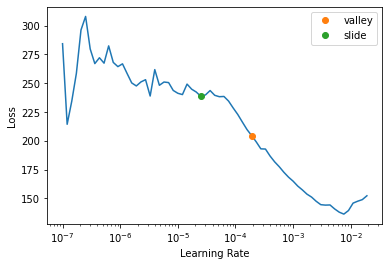

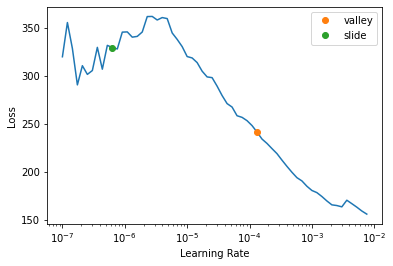

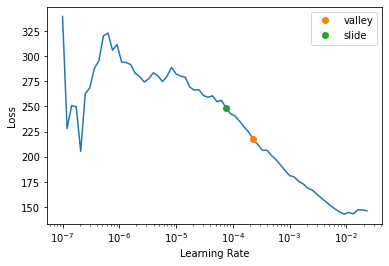

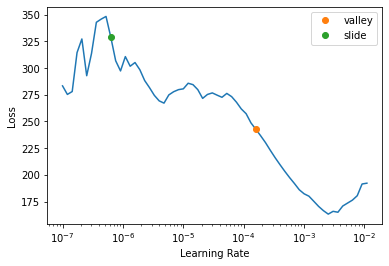

In [25]:
#in here we are going to do both our training and inference using resnet34 architecture
#I have also used alot of advanced techniques like callbacks and if you dont understand please visit the official fastai.docs
all_preds = []

for i in range(5):
    dls = get_data(i,16)
    learn = Learner(dls, Net(), 
                loss_func=MSELossFlat(), metrics=[rmse,mae],

                cbs=[SaveModelCallback(),]
        )
#     learn.fit_one_cycle(10)
#     learn.dls = get_data(i,224,8)
    _valley, _slide = learn.lr_find(suggest_funcs=(valley,slide))
    learn.fine_tune(15,_valley)
    
    tst_dl = learn.dls.test_dl(Test)
    preds, _ = learn.tta(dl=tst_dl, n=5)
    all_preds.append(preds)
    del learn
    torch.cuda.empty_cache()
    gc.collect()

In [26]:
# learn.recorder.final_record 

### Aggregating predictions

In [27]:
preds = np.mean(np.stack(all_preds), axis=0)

In [28]:
k=[]
for col in Test.columns: 
  k.append(col) # creating list of the label

k

['ImageId']

In [29]:
len(preds), preds.shape

(858, (858, 1))

### Submissions

In [30]:
Test['ImageId'] = Test['ImageId'].str.replace('/kaggle/input/trees-project/tree_project/tree_project/TreeImages/', '')

In [31]:
Test.head()

,ImageId
0,Id_ohk78h9ld8.png
1,Id_eeyj2u4j7y.png
2,Id_wsd7vx2ifa.png
3,Id_6vfneamaoh.png
4,Id_9wil3575fv.png


In [32]:
Test['Target'] = 0
Test.head()

,ImageId,Target
0,Id_ohk78h9ld8.png,0
1,Id_eeyj2u4j7y.png,0
2,Id_wsd7vx2ifa.png,0
3,Id_6vfneamaoh.png,0
4,Id_9wil3575fv.png,0


In [33]:
Test['Target']= preds
Test.head()

,ImageId,Target
0,Id_ohk78h9ld8.png,0.027461
1,Id_eeyj2u4j7y.png,0.020230
2,Id_wsd7vx2ifa.png,13.677876
3,Id_6vfneamaoh.png,12.496436
4,Id_9wil3575fv.png,15.036547


In [34]:

print(Test.shape)
Test.to_csv('conv_daniel_1.csv', index=False)



(858, 2)


In [35]:
Test.describe()

,Target
count,858.000000
mean,10.041101
std,13.426527
min,-0.347532
25%,0.030583
50%,2.371935
75%,16.430976
max,47.590618


In [36]:
Test['Target'] = np.where(Test['Target']< 0, 0, Test['Target'])
Test.to_csv('conv_daniel_mod_1.csv', index=False)
Test.describe()

,Target
count,858.000000
mean,10.047522
std,13.421673
min,0.000000
25%,0.030583
50%,2.371935
75%,16.430976
max,47.590618
